In [22]:
import os, importlib, sys, time

In [23]:
import numpy as np
import scipy.sparse as sparse
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [24]:
import KECENI

# load data

In [25]:
data_dir = 'data'
save_dir = 'result'

In [26]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)

In [27]:
data_network

,row,col
0,1,5
1,1,17
2,2,3
3,2,9
4,3,2
...,...,...
2169,599,538
2170,599,560
2171,600,384
2172,600,454


In [28]:
n_node = len(data_latent); n_node

600

In [29]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
), shape=(n_node,n_node)).toarray()

In [30]:
G = KECENI.Graph(Adj)

# hyperparameters

In [31]:
from hyperparams import delta

# counterfactual of interest

In [32]:
i0 = 0

In [33]:
T0s_0 = np.full(n_node, 0)
T0s_1 = np.full(n_node, 1)

In [34]:
T0s_0[G.N1(i0)], T0s_1[G.N1(i0)]

(array([0, 0, 0]), array([1, 1, 1]))

In [35]:
i0s = np.array([i0])
T0s = np.array([T0s_0, T0s_1])

# groundtruth

In [36]:
YTR_0, YTR_1 = (-2, 2)
YTR_d = YTR_1 - YTR_0

In [37]:
YTR_0, YTR_1, YTR_d

(-2, 2, 4)

# estimation

In [38]:
n_sim = 80

## - load simulation

In [39]:
lamdas = np.linspace(0, 20, 21)[1:]
hops = np.array([5,6,7,8])

In [40]:
ids_cv = np.zeros(n_sim, dtype=int)

In [41]:
YGs_0 = np.zeros(n_sim); YGs_1 = np.zeros(n_sim); YGs_d = np.zeros(n_sim)
YDRs_0 = np.zeros(n_sim); YDRs_1 = np.zeros(n_sim); YDRs_d = np.zeros(n_sim)

In [42]:
for i_sim in np.arange(n_sim):
    locals().update(np.load('%s/result_%.3d.npz'%(save_dir,i_sim)))
    YGs_0[i_sim] = YG_0; YGs_1[i_sim] = YG_1; YGs_d[i_sim] = YG_d
    YDRs_0[i_sim] = YDR_0[id_cv]; YDRs_1[i_sim] = YDR_1[id_cv]; YDRs_d[i_sim] = YDR_d[id_cv]

## - G estimate

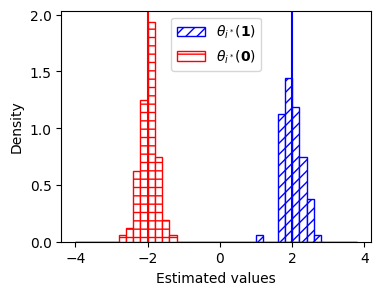

In [43]:
fig = plt.figure(figsize=(4,3))
plt.hist(YGs_1, density=True, bins=np.arange(-4,4,0.2), 
         facecolor='white', edgecolor='blue', hatch="///", 
         label=r'$\theta_{i^*}(\mathbf{1})$')
plt.axvline(YTR_1, color='blue')
plt.hist(YGs_0, density=True, bins=np.arange(-4,4,0.2), 
         facecolor='white', edgecolor='red', hatch="--",
         label=r'$\theta_{i^*}(\mathbf{0})$')
plt.axvline(YTR_0, color='red')
plt.xlabel('Estimated values'); plt.ylabel('Density'); plt.legend()

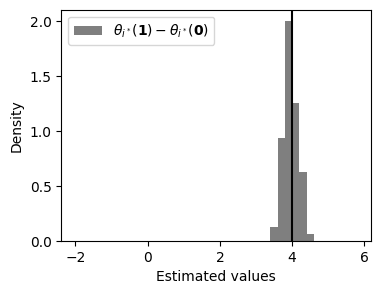

In [44]:
fig = plt.figure(figsize=(4,3))
plt.hist(YGs_d, color='black', alpha=0.5, density=True, bins=np.arange(-2,6,0.2),
         label=r'$\theta_{i^*}(\mathbf{1}) - \theta_{i^*}(\mathbf{0})$')
plt.axvline(YTR_d, color='black')
plt.xlabel('Estimated values'); plt.ylabel('Density'); plt.legend()

In [45]:
np.sqrt(np.mean((YGs_d - YTR_d)**2, 0))

0.1998006885181409

## - KECENI

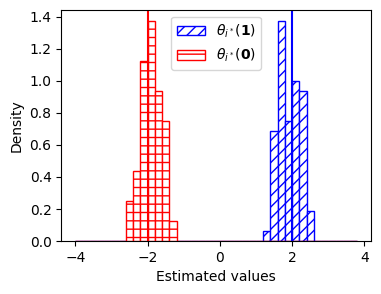

In [46]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_1, density=True, bins=np.arange(-4,4,0.2), 
         facecolor='white', edgecolor='blue', hatch="///", 
         label=r'$\theta_{i^*}(\mathbf{1})$')
plt.axvline(YTR_1, color='blue')
plt.hist(YDRs_0, density=True, bins=np.arange(-4,4,0.2), 
         facecolor='white', edgecolor='red', hatch="--",
         label=r'$\theta_{i^*}(\mathbf{0})$')
plt.axvline(YTR_0, color='red')
plt.xlabel('Estimated values'); plt.ylabel('Density'); plt.legend()

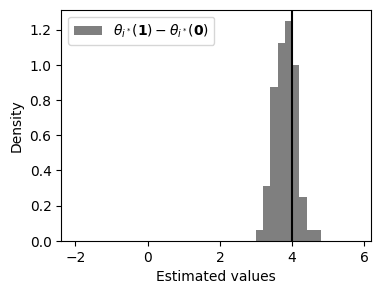

In [47]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_d, color='black', alpha=0.5, 
         density=True, bins=np.arange(-2,6,0.2), 
         label=r'$\theta_{i^*}(\mathbf{1}) - \theta_{i^*}(\mathbf{0})$')
plt.axvline(YTR_d, color='black')
plt.xlabel('Estimated values'); plt.ylabel('Density'); plt.legend()

In [51]:
np.sqrt(np.mean((YDRs_d - YTR_d)**2, 0))

0.3421165091837184

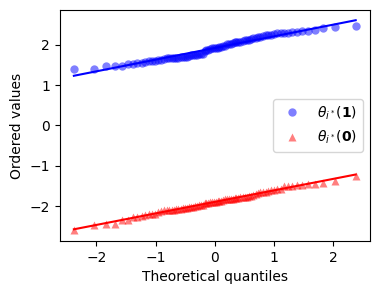

In [49]:
fig = plt.figure(figsize=(4,3)); ax=plt.gca()
stats.probplot(YDRs_1, dist="norm", plot=ax)
stats.probplot(YDRs_0, dist="norm", plot=ax)

ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[0].set_marker('o')
ax.get_lines()[0].set(alpha=0.5)
ax.get_lines()[0].set_markeredgecolor('none')
ax.get_lines()[1].set(color='blue')
ax.get_lines()[2].set_markerfacecolor('red')
ax.get_lines()[2].set_marker('^')
ax.get_lines()[2].set(alpha=0.5)
ax.get_lines()[2].set_markeredgecolor('none')
ax.get_lines()[3].set(color='red')

ax.legend([ax.get_lines()[0], ax.get_lines()[2]], 
          [r'$\theta_{i^*}(\mathbf{1})$', r'$\theta_{i^*}(\mathbf{0})$'])

plt.xlabel('Theoretical quantiles'); plt.ylabel('Ordered values')
plt.title(''); plt.show()

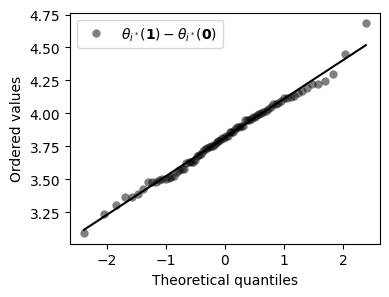

In [50]:
fig = plt.figure(figsize=(4,3)); ax=plt.gca()

stats.probplot(YDRs_d, dist="norm", plot=plt)

ax.get_lines()[0].set_markerfacecolor('black')
ax.get_lines()[0].set(alpha=0.5)
ax.get_lines()[0].set_markeredgecolor('none')
ax.get_lines()[1].set(color='black')

ax.legend([ax.get_lines()[0]], 
          [r'$\theta_{i^*}(\mathbf{1}) - \theta_{i^*}(\mathbf{0})$'])

plt.xlabel('Theoretical quantiles'); plt.ylabel('Ordered values')
plt.title(''); plt.show()